Gene conservation cache exists
Caching data...
Status plot created


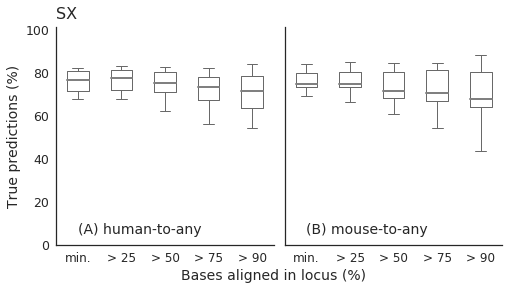

In [28]:
%matplotlib inline

import os as os
import numpy as np
import numpy.random as rng
import json as js
import csv as csv
import pickle as pck
import collections as col
import operator as op
import functools as fnt
import warnings as warn

import sklearn.exceptions as skle

warn.filterwarnings('error', message='Precision.+', category=skle.UndefinedMetricWarning)

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# What is this?
# Plot model performance for different
# thresholds of (joint) promoter/gene body
# conservation

date = '20181121'

sns.set(style='white',
        font_scale=1.25,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis'
stat_folder = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/task_summarize')
stat_file = os.path.join(stat_folder, 'agg_expstat_est.h5')
testdata_folder = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/task_testdata_exp/test_datasets')

cache_dir = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/caching/notebooks')

conf_folder = '/home/pebert/work/code/mpggit/crossspecies/graphics'
ref_folder = '/home/pebert/work/code/mpggit/refdata/annotation'

plot_labels = js.load(open(os.path.join(conf_folder, 'labels', 'cs_labels.json'), 'r'))
plot_colors = js.load(open(os.path.join(conf_folder, 'colors', 'cs_colors.json'), 'r'))
plot_shapes = js.load(open(os.path.join(conf_folder, 'shapes', 'cs_shapes.json'), 'r'))
species_file = os.path.join(ref_folder, 'species.tsv')

run_exec_perf_aln = True

show_figures = False

out_folder = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/crossspecies/figures/pub'
diss_folder = '/home/pebert/work/code/mpggit/dissertation/Figures'
save_figures = False
save_diss = False

def exec_status():
    cache_data = os.path.join(cache_dir, '{}_plot_model_perf_aln.h5'.format(date))
    cache_keys = os.path.join(cache_dir, '{}_plot_model_perf_aln.keys.pck'.format(date))
    if not os.path.isfile(cache_keys):
        with pd.HDFStore(stat_file, 'r') as hdf:
            stat_keys = list(hdf.keys())
        with open(cache_keys, 'wb') as cache:
            _ = pck.dump(stat_keys, cache)
    else:
        with open(cache_keys, 'rb') as cache:
            stat_keys = pck.load(cache)
        
    fullmodel = 'can'
    comparison = 'pos'
    if os.path.isfile(cache_data):
        with pd.HDFStore(cache_data, 'r') as hdf:
            perf_scores = hdf['perf_scores']        
    else:
        print('Collecting model performance...')
        gene_cons_cache = os.path.join(cache_dir, '{}_gene_cons_cache.h5'.format(date))
        _ = cache_gene_cons(gene_cons_cache)

        perf_scores = collect_performances(stat_file, stat_keys,
                                           gene_cons_cache,
                                           fullmodel, comparison)
        print('Caching data...')
        with pd.HDFStore(cache_data, 'w', complib='blosc', complevel=9) as hdf:
            hdf.put('perf_scores', perf_scores, format='table')
    fig_key = 'SX'
    subfolder = 'supp'
    fig, exart = plot_aln_perf_boxes(perf_scores, fig_key, save_diss)
    if save_figures:
        outname = 'fig_{}_aln_perf'.format(fk)

        if save_diss:
            out_folder = diss_folder
            subfolder = 'crossspecies'

        if not save_diss:
            outpath = os.path.join(out_folder, subfolder, 'raw', outname + '.svg')
            fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')

            outpath = os.path.join(out_folder, subfolder, 'png', outname + '.png')
            fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight', dpi=300)

        outpath = os.path.join(out_folder, subfolder, outname + '.pdf')
        fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
                
    return True
   
    
def plot_aln_perf_boxes(scores, key, diss_version):
    """
    """
    fig, (ax1, ax2) = plt.subplots(figsize=(8, 4),
                                   ncols=2, nrows=1,
                                   sharex=True, sharey=True)
    plt.subplots_adjust(wspace=0.05)
    
    extra_artists = []
    boxcolor = 'dimgrey'
    medcolor = 'grey'
    median_props = {'color': medcolor, 'linewidth': 2}
    box_props = {'color': boxcolor, 'linewidth': 1}
    whisker_props = {'color': boxcolor, 'linewidth': 1}
    cap_props = {'color': boxcolor, 'linewidth': 1}
    
    box_labels = ['min.', '> 25', '> 50', '> 75', '> 90']
    
    ax1.set_xlim(0.5, 6.5)
    ax1.set_ylim(0, 101)
    xl = ax1.set_xlabel('Bases aligned in locus (%)', fontsize=14)
    xl.set_position([1, 0])
    ax1.set_ylabel('True predictions (%)', fontsize=14)
    
    hsa_boxes = extract_box_values(scores.loc[scores['target'] == 'human', ['aln_pct', 'true_pct']].copy())
    ax1.boxplot(hsa_boxes, sym="", labels=None,
                medianprops=median_props, boxprops=box_props,
                whiskerprops=whisker_props, capprops=cap_props)
    ax1.set_xticklabels(box_labels, fontsize=12)
    ax1.text(1, 5, '(A) human-to-any', fontdict={'fontsize': 14})
    
    mmu_boxes = extract_box_values(scores.loc[scores['target'] == 'mouse', ['aln_pct', 'true_pct']].copy())
    ax2.boxplot(mmu_boxes, sym="", labels=None,
                medianprops=median_props, boxprops=box_props,
                whiskerprops=whisker_props, capprops=cap_props)
    ax2.set_xticklabels(box_labels, fontsize=12)
    ax2.text(1, 5, '(B) mouse-to-any', fontdict={'fontsize': 14})
    
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    if not save_diss:
        tt = ax1.set_title(key, fontsize=16)
        tt.set_position([0.05, 1.01])
    return fig, extra_artists


def extract_box_values(data):
    boxes = []
    for b in [0, 25, 50, 75, 90]:
        values = data.loc[data['aln_pct'] == b, 'true_pct']
        boxes.append(values)
    return boxes


def cache_gene_cons(gene_cons_cache):
    
    if os.path.isfile(gene_cons_cache):
        print('Gene conservation cache exists')
        return gene_cons_cache
    else:
        with pd.HDFStore(gene_cons_cache, 'w') as hdf:
            pass
    
    feat_columns = ['chrom', 'name', 'symbol',
                    'start_body', 'end_body',
                    'start_reg5p', 'end_reg5p',
                    'ftlen_abs_length_reg5p',
                    'ftmsig_H3K4me3_pct_cons_reg5p',
                    'ftlen_abs_length_body',
                    'ftmsig_H3K36me3_pct_cons_body']
    
    done = set()
    for root, dirs, featfiles in os.walk(testdata_folder):
        loadfiles = [ff for ff in featfiles if ff.startswith('G9930') and ff.endswith('.feat.h5')]
        for ff in loadfiles:
            fpath = os.path.join(root, ff)

            trg, qry = None, None
            cc = 0
            data_buffer = []
            with pd.HDFStore(fpath, 'r') as hdf:
                for k in hdf.keys():
                    if k.startswith('/metadata'):
                        continue
                    data = hdf[k]
                    _, qry, _, trg, _, _, chrom = k.split('/')
                    qry_spec = plot_colors['mapping'][qry]['species']
                    trg_spec = plot_colors['mapping'][trg]['species']
                    
                    data['chrom'] = chrom
                    data = data.loc[:, feat_columns].copy()

                    data['promoter_cons_bp'] = (data['ftlen_abs_length_reg5p'] * \
                                                (data['ftmsig_H3K4me3_pct_cons_reg5p'] / 100.)).round(0).astype(np.int32)
                    data['body_cons_bp'] = (data['ftlen_abs_length_body'] * \
                                           (data['ftmsig_H3K36me3_pct_cons_body'] / 100.)).round(0).astype(np.int32)
                    data['bp_cons_locus'] = data['promoter_cons_bp'] + data['body_cons_bp']
                    data['ftlen_abs_length_locus'] = data['ftlen_abs_length_reg5p'] + data['ftlen_abs_length_body']
                    
                    #data['pct_cons_locus'] = data['ftmsig_H3K4me3_pct_cons_reg5p'] + data['ftmsig_H3K36me3_pct_cons_body']
                    #data['pct_cons_locus'] /= 2.
                    #data['pct_cons_locus'] = data['pct_cons_locus'].round(2)
                    data['pct_cons_locus'] = (data['bp_cons_locus'] / data['ftlen_abs_length_locus']).round(3) * 100

                    data['unaln'] = ((data['body_cons_bp'] < 1) & (data['promoter_cons_bp'] < 1)).astype(np.int8)
                    data['wkaln'] = ((data['body_cons_bp'] < 100) & (data['promoter_cons_bp'] < 100)).astype(np.int8)

                    data['is_aligned'] = ((data['unaln'] < 1) & (data['wkaln'] < 1)).astype(np.int8)

                    data_buffer.append(data)
            data = pd.concat(data_buffer, axis=0, ignore_index=True)
            if (trg, qry) in done:
                raise ValueError('Duplicate entry for {} v {}'.format(trg, qry))
            with pd.HDFStore(gene_cons_cache, 'a') as hdf:
                hdf.put('{}/{}'.format(trg, qry), data, format='fixed')
                hdf.put('{}/{}'.format(trg_spec, qry_spec), data, format='fixed')
                
    return gene_cons_cache


def load_gene_cons_annotation(fpath, target, query):
    
    with pd.HDFStore(fpath, 'r') as hdf:
        annotation = hdf['/'.join(['', target, query])]
        annotation.index = annotation['name']
    return annotation


def collect_performances(model_file, model_keys, gene_cache, model_type, comparison):
    
    filter_key = '/{}/{}'.format(comparison, model_type)
    load_keys = [k for k in model_keys if k.startswith(filter_key) and k.endswith('/data') and
                 'G99' not in k]
    row_buffer = []
    with pd.HDFStore(model_file, 'r') as hdf:
        
        for lk in load_keys:
            key_parts = lk.split('/')
            trg, qry = key_parts[3:5]
            
            model_data = hdf[lk]
            gene_data = load_gene_cons_annotation(gene_cache, trg, qry)
            model_data = model_data.loc[model_data.index.isin(gene_data['name']), ['tp', 'tn']].copy()
            model_data = model_data.join(gene_data, how='outer')
            total_genes = model_data.shape[0]
            model_data = model_data.loc[model_data['is_aligned'] > 0, ['tp', 'tn', 'pct_cons_locus']].copy()
            aligned_genes = model_data.shape[0]
            
            for bound in [0, 25, 50, 75, 90]:
                selector = np.array(model_data['pct_cons_locus'] > bound, dtype=np.bool)
                subset = model_data.loc[selector, ['tp', 'tn']]
                subset_size = subset.shape[0]
                true_preds = subset['tn'].sum() + subset['tp'].sum()
                pct_true = (true_preds / subset_size) * 100
                row_buffer.append((trg, qry, total_genes, aligned_genes, bound, subset_size, true_preds, pct_true))
                         
    cache_data = pd.DataFrame(row_buffer, columns=['target', 'query', 'total_genes',
                                                   'aligned_genes', 'aln_pct',
                                                   'subset', 'true_pred', 'true_pct'])
    return cache_data

if run_exec_perf_aln:
    execd = exec_status()
    print('Status plot created')
